In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sn
from pickle import NONE

import nltk
from nltk.corpus import brown

emissionMat = []
transitionMat = []
startWords = []

alpha = 0.4

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
def viterbi(sentences):
    global emissionMat, transitionMat, startWords, alpha, uniqueWords, uniqueTags, mapWords, mapTags
    wordCount = len(uniqueWords)
    tagCount = len(uniqueTags)
    tagList = []
    a = time.time()
    probTagsToWords = (tagsToWords + alpha)/(tagsToWords.sum(axis=1, keepdims=True) + alpha*wordCount)
    probTagsToTags = (tagsToTags + alpha)/(tagsToTags.sum(axis=1, keepdims=True) + alpha*tagCount)

    tagCounts = tagsToTags.sum(axis = 1)

    for sentence in sentences:
        L = len(sentence)
        probTagSeq = np.zeros((L, tagCount))
        pred = np.zeros((L, tagCount))
        sentenceTags = np.zeros(L, dtype = np.int64)

        for i in range(0, L):
            wordin = mapWords.get(sentence[i])
            if (i == 0):
                for tag in uniqueTags:
                    tagin = mapTags[tag]
                    emissionProb = 0
                    transitionProb = 0
                    if (wordin):
                        emissionProb = probTagsToWords[tagin][wordin]
                    else:
                        emissionProb = alpha/(tagCounts[tagin] + alpha*wordCount)
                    transitionProb = startWords[tagin]/np.sum(startWords)
                    probTagSeq[i][tagin] = np.log(emissionProb) + np.log(transitionProb)
            else:
                for tag in uniqueTags:
                    tagin = mapTags[tag]
                    maxTag = 0
                    maxProb = -np.inf
                    for prevTag in uniqueTags:
                        tagind = mapTags[prevTag]
                        emissionProb = 0
                        transitionProb = 0
                        if (wordin):
                            emissionProb = probTagsToWords[tagin][wordin]
                        else:
                            emissionProb = alpha/(tagCounts[tagin] + alpha*wordCount)
                        transitionProb = probTagsToTags[tagind][tagin]
                        if (np.log(emissionProb) + np.log(transitionProb) + probTagSeq[i-1][tagind] > maxProb):
                            maxProb = np.log(emissionProb) + np.log(transitionProb) + probTagSeq[i-1][tagind]
                            maxTag = tagind
                    pred[i][tagin] = maxTag
                    probTagSeq[i][tagin] = maxProb

        lastTag = 0
        maxProbability = -np.inf

        for tag in uniqueTags:
            tagin = mapTags[tag]
            if (probTagSeq[L-1][tagin] > maxProbability):
                maxProbability = probTagSeq[L-1][tagin]
                lastTag = tagin
                lastTag = int(lastTag)
        sentenceTags[L-1] = lastTag
        for j in range(L-1):
            lastTag = int(lastTag)
            lastTag = pred[L-1-j][lastTag]
            sentenceTags[L-2-j] = lastTag
        sentenceTags = list(sentenceTags)
        tagList.append(sentenceTags)
    return tagList

In [4]:
'''
Function for caculating F-Score given precision and recall
'''
def FScore(precision, recall, beta):
    fscore = ((1+beta*beta)*precision*recall)/(beta*beta*precision + recall)
    return fscore

In [5]:
'''
Extracting data
'''
x = brown.tagged_sents(tagset='universal')
sentenceCount = len(x)  # Total number of sentences

tags = [j[1] for i in x for j in i]
words = [j[0] for i in x for j in i]

lens = np.array([len(x) for x in words])

N = len(tags)
print("Total number of words :", len(tags))

uniqueWords = set(words)
uniqueWords = list(uniqueWords)
print("Number of unique words :", len(uniqueWords))

uniqueTags = set(tags)
uniqueTags = list(uniqueTags)
print("Unique tags :", uniqueTags)

wordCount = len(uniqueWords)  # Number of unique words
tagCount = len(uniqueTags)  # Number of unique tags

'''
Index of the word in list of unique words 
'''
mapWords = {}
for i in range(len(uniqueWords)):
    mapWords[uniqueWords[i]] = i

'''
Index of a tag in list of unique tags
'''
mapTags = {}
for i in range(len(uniqueTags)):
    mapTags[uniqueTags[i]] = i


'''
Creating folds
'''
lenOfFold = int(np.floor(sentenceCount/5))
foldIndices = [[0, lenOfFold],
               [lenOfFold, 2*lenOfFold],
               [2*lenOfFold, 3*lenOfFold],
               [3*lenOfFold, 4*lenOfFold],
               [4*lenOfFold, sentenceCount]]

perFoldTagsToWords = np.zeros((5, tagCount, wordCount), dtype=np.int64)
perFoldTagsToTags = np.zeros((5, tagCount, tagCount), dtype=np.int64)
perFoldStartWords = np.zeros((5, tagCount), dtype=np.int64)

'''
Calculate tag to tag and tag to word count for each fold
'''
for i in range(5):
    for j in range(foldIndices[i][0], foldIndices[i][1]):
        curSentence = x[j]
        perFoldStartWords[i][mapTags[curSentence[0][1]]] += 1
        for k in x[j]:
            indexOfWord = mapWords[k[0]]
            indexOfTag = mapTags[k[1]]
            perFoldTagsToWords[i][indexOfTag][indexOfWord] += 1

        columnSum = np.sum(perFoldTagsToTags, axis=0)

        for l in range(1, len(x[j])):
            curTag = curSentence[l][1]
            prevTag = curSentence[l-1][1]

            perFoldTagsToTags[i][mapTags[prevTag]][mapTags[curTag]] += 1

'''
Define metric matrices. For each fold we get a value for each tag
'''
Precision = np.zeros((5, tagCount))
Recall = np.zeros((5, tagCount))
F1Score = np.zeros((5, tagCount))
F05Score = np.zeros((5, tagCount))
F2Score = np.zeros((5, tagCount))
ConfusionMatrix = np.zeros((5, tagCount, tagCount))

'''
Weighted metric values for each fold
'''
weightedPrecision = np.zeros(5)
weightedRecall = np.zeros(5)
weightedF1Score = np.zeros(5)
weightedF05Score = np.zeros(5)
weightedF2Score = np.zeros(5)

'''
5-Fold cross validation
'''
for i in range(5):
    '''
    Training phase. Populating the transition and emission matrices
    '''
    tagsToWords = np.zeros((tagCount, wordCount), dtype=np.int64)
    tagsToTags = np.zeros((tagCount, tagCount), dtype=np.int64)
    startWords = np.zeros(tagCount, dtype = np.int64)
    for j in range(5):
        if (j != i):
            tagsToWords += perFoldTagsToWords[j]
            tagsToTags += perFoldTagsToTags[j]
            startWords += perFoldStartWords[j]

    probTagsToWords = (tagsToWords + alpha)/(tagsToWords.sum(axis=1, keepdims=True) + alpha*wordCount)
    probTagsToTags = (tagsToTags + alpha)/(tagsToTags.sum(axis=1, keepdims=True) + alpha*tagCount)

    emissionMat = tagsToWords
    transitionMat = tagsToTags

    sentences = []
    trueTagList = []
    testTagsCount = np.zeros(tagCount)

    '''
    Separate words and tags in test sentences
    'sentences' contains a list of sentences
    Each 'sentence' is a list of words
    '''
    for j in x[foldIndices[i][0]: foldIndices[i][1]]:
        sentence = [k[0] for k in j]
        trueTags = [k[1] for k in j]
        sentences.append(sentence)
        trueTagList.append(trueTags)

    '''
    Testing phase
    '''
    predictedTagList = viterbi(sentences)

    '''
    Confusion matrix
    '''
    confusionMatrix = np.zeros((tagCount, tagCount), dtype=np.int64)
    for j in range(len(trueTagList)):
        for k in range(len(trueTagList[j])):
            trueTagIn = mapTags[trueTagList[j][k]]
            predictedTagIn = predictedTagList[j][k]

            confusionMatrix[trueTagIn][predictedTagIn] += 1

    testTagsCount = np.sum(confusionMatrix, axis = 1)
    totalTestTags = np.sum(confusionMatrix)

    TP = np.zeros(tagCount)
    FP = np.zeros(tagCount)
    FN = np.zeros(tagCount)
    for j in range(tagCount):
        TP[j] = confusionMatrix[j][j]
        FN[j] = np.sum(confusionMatrix[j]) - TP[j]
        FP[j] = np.sum(confusionMatrix[:, j]) - TP[j]
    
    '''
    Calculating metrics for each fold
    '''
    Precision[i] = (TP/(TP + FP))
    Recall[i] = (TP/(TP + FN))
    F1Score[i] = FScore(Precision[i], Recall[i], 1.0)
    F05Score[i] = FScore(Precision[i], Recall[i], 0.5)
    F2Score[i] = FScore(Precision[i], Recall[i], 2)

    '''
    Calculating weighted metrics for each fold
    '''
    weightedPrecision[i] = np.sum(Precision[i]*testTagsCount)/totalTestTags
    weightedRecall[i] = np.sum(Recall[i]*testTagsCount)/totalTestTags
    weightedF1Score[i] = np.sum(F1Score[i]*testTagsCount)/totalTestTags
    weightedF05Score[i] = np.sum(F05Score[i]*testTagsCount)/totalTestTags
    weightedF2Score[i] = np.sum(F2Score[i]*testTagsCount)/totalTestTags

    ConfusionMatrix[i] = confusionMatrix

Total number of words : 1161192
Number of unique words : 56057
Unique tags : ['ADJ', 'X', 'ADV', 'ADP', 'PRON', 'PRT', 'NOUN', 'CONJ', 'VERB', 'DET', '.', 'NUM']


Fold 1 :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Precision,0.84897,0.313539,0.86018,0.909394,0.826421,0.906905,0.963039,0.955921,0.967168,0.904289,0.918678,0.983909


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Recall,0.890027,0.469751,0.888798,0.973686,0.944783,0.85961,0.852792,0.993474,0.916397,0.989238,0.999701,0.830901


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F1-score,0.869014,0.376068,0.874255,0.940443,0.881647,0.882624,0.904569,0.974336,0.941098,0.944858,0.957479,0.900955


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F0.5-score,0.856876,0.335878,0.865755,0.921564,0.84766,0.897034,0.938767,0.963203,0.956569,0.920091,0.933815,0.94896


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F2-score,0.881501,0.427184,0.882923,0.960111,0.918474,0.86867,0.872775,0.985729,0.92612,0.970995,0.982373,0.857573


Confusion Matrix :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
ADJ,16858.0,24.0,600.0,97.0,64.0,19.0,524.0,23.0,128.0,465.0,136.0,3.0
X,13.0,132.0,1.0,10.0,3.0,2.0,80.0,0.0,1.0,18.0,21.0,0.0
ADV,485.0,3.0,9751.0,355.0,44.0,93.0,76.0,18.0,22.0,82.0,42.0,0.0
ADP,11.0,1.0,344.0,30231.0,61.0,298.0,8.0,33.0,22.0,39.0,0.0,0.0
PRON,0.0,0.0,1.0,407.0,7751.0,0.0,3.0,0.0,0.0,38.0,4.0,0.0
PRT,15.0,0.0,44.0,686.0,9.0,4978.0,28.0,1.0,11.0,5.0,14.0,0.0
NOUN,1894.0,224.0,321.0,953.0,1198.0,87.0,56958.0,204.0,959.0,1728.0,2213.0,51.0
CONJ,0.0,1.0,29.0,3.0,0.0,0.0,0.0,7612.0,0.0,17.0,0.0,0.0
VERB,499.0,8.0,207.0,322.0,61.0,7.0,1258.0,58.0,34024.0,509.0,175.0,0.0
DET,1.0,0.0,9.0,146.0,149.0,1.0,3.0,4.0,0.0,29138.0,4.0,0.0


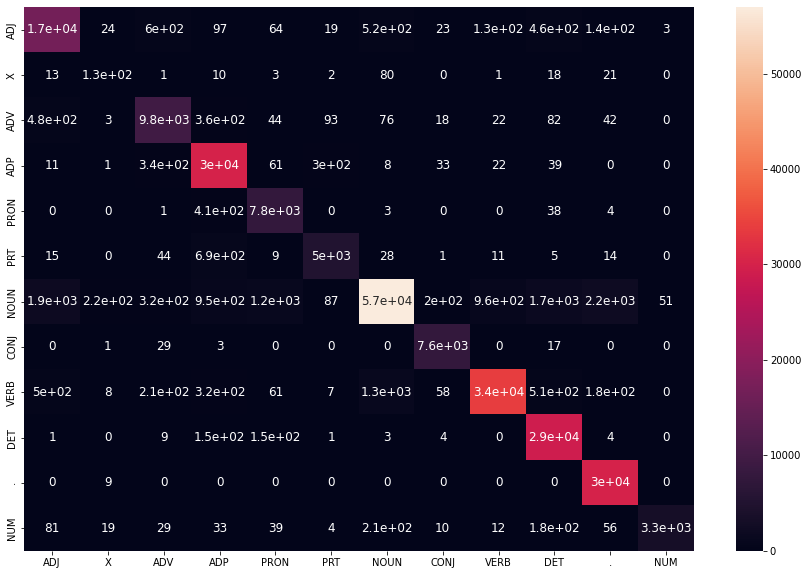

,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Precision,0.871586,0.278351,0.854364,0.922941,0.845778,0.899729,0.954487,0.967582,0.97032,0.925124,0.939137,0.982652


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Recall,0.885135,0.409091,0.876382,0.970411,0.948521,0.874406,0.886113,0.99132,0.900763,0.991805,0.999395,0.818036


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F1-score,0.878308,0.331288,0.865233,0.946081,0.894208,0.886887,0.91903,0.979307,0.934249,0.957305,0.968329,0.89282


Weighted Precision : 0.9252227133426042
Weighted Recall : 0.9220362677744048
Weighted F1-score : 0.9217469685970849
Weighted F0.5-score : 0.9233679258782096
Weighted F2-score : 0.921478478230725
Fold 2 :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F0.5-score,0.874262,0.297357,0.858679,0.93206,0.864507,0.894547,0.939981,0.972238,0.955562,0.937733,0.9506,0.944634


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F2-score,0.882392,0.373961,0.871888,0.96053,0.926023,0.879356,0.898993,0.98648,0.913865,0.977711,0.986732,0.846394


Confusion Matrix :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
ADJ,17423.0,21.0,657.0,76.0,77.0,36.0,575.0,23.0,145.0,489.0,162.0,0.0
X,21.0,108.0,1.0,5.0,4.0,0.0,77.0,1.0,1.0,19.0,27.0,0.0
ADV,553.0,0.0,10542.0,488.0,44.0,108.0,84.0,31.0,37.0,86.0,56.0,0.0
ADP,13.0,2.0,453.0,31320.0,66.0,331.0,16.0,30.0,7.0,32.0,4.0,1.0
PRON,0.0,0.0,2.0,403.0,8144.0,0.0,8.0,1.0,3.0,25.0,0.0,0.0
PRT,9.0,0.0,40.0,627.0,1.0,4971.0,29.0,0.0,2.0,3.0,3.0,0.0
NOUN,1376.0,193.0,334.0,456.0,1006.0,74.0,53772.0,115.0,849.0,1114.0,1350.0,44.0
CONJ,0.0,0.0,47.0,6.0,1.0,0.0,0.0,8566.0,0.0,21.0,0.0,0.0
VERB,561.0,14.0,246.0,438.0,103.0,1.0,1551.0,68.0,34229.0,564.0,225.0,0.0
DET,0.0,0.0,6.0,92.0,141.0,0.0,5.0,5.0,0.0,30135.0,0.0,0.0


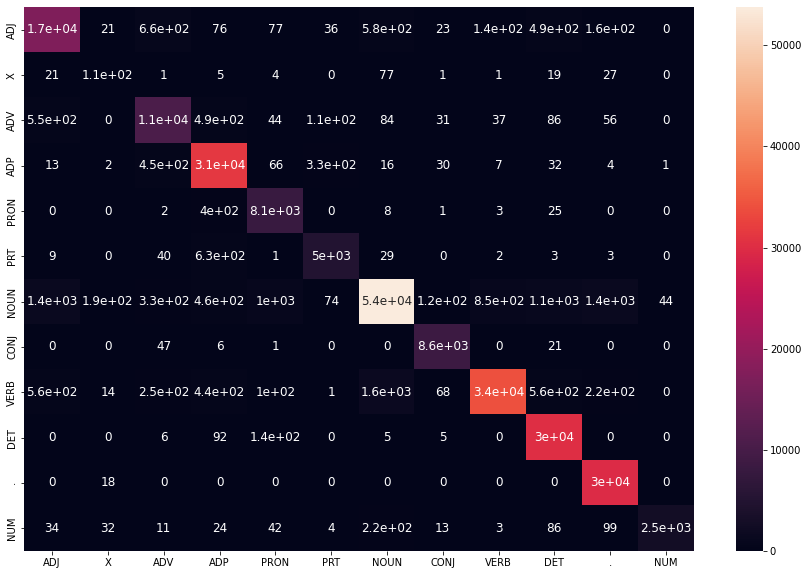

Weighted Precision : 0.9311071071970045
Weighted Recall : 0.9293170175523117
Weighted F1-score : 0.9291463335455992
Weighted F0.5-score : 0.930063089634067
Weighted F2-score : 0.9289956878291286
Fold 3 :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Precision,0.887005,0.528061,0.856172,0.945715,0.835005,0.895025,0.961591,0.977806,0.973128,0.913728,0.940488,0.975572


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Recall,0.877289,0.465169,0.88418,0.97147,0.977871,0.892348,0.896553,0.992917,0.921969,0.990912,0.999544,0.843486


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F1-score,0.88212,0.494624,0.86995,0.95842,0.900809,0.893684,0.927934,0.985304,0.946858,0.950756,0.969117,0.904734


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F0.5-score,0.885045,0.514158,0.86163,0.950756,0.860138,0.894488,0.947839,0.980791,0.962447,0.928188,0.951734,0.945946


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F2-score,0.879215,0.476519,0.878433,0.966208,0.945516,0.892882,0.908847,0.989857,0.931766,0.974449,0.987147,0.866962


Confusion Matrix :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
ADJ,19303.0,17.0,646.0,110.0,63.0,53.0,741.0,25.0,143.0,702.0,200.0,0.0
X,20.0,207.0,8.0,22.0,10.0,6.0,87.0,4.0,30.0,28.0,23.0,0.0
ADV,526.0,4.0,10703.0,424.0,67.0,81.0,86.0,17.0,21.0,104.0,72.0,0.0
ADP,9.0,5.0,459.0,37456.0,70.0,339.0,13.0,41.0,39.0,95.0,30.0,0.0
PRON,1.0,3.0,1.0,124.0,7910.0,1.0,13.0,1.0,3.0,28.0,4.0,0.0
PRT,6.0,0.0,54.0,519.0,6.0,5073.0,13.0,2.0,5.0,3.0,4.0,0.0
NOUN,1317.0,95.0,367.0,544.0,1074.0,95.0,61387.0,92.0,784.0,1339.0,1281.0,95.0
CONJ,0.0,1.0,33.0,1.0,0.0,0.0,2.0,9252.0,0.0,29.0,0.0,0.0
VERB,526.0,16.0,190.0,277.0,58.0,6.0,1286.0,23.0,37372.0,579.0,202.0,0.0
DET,0.0,4.0,8.0,102.0,170.0,1.0,2.0,4.0,2.0,32600.0,6.0,0.0


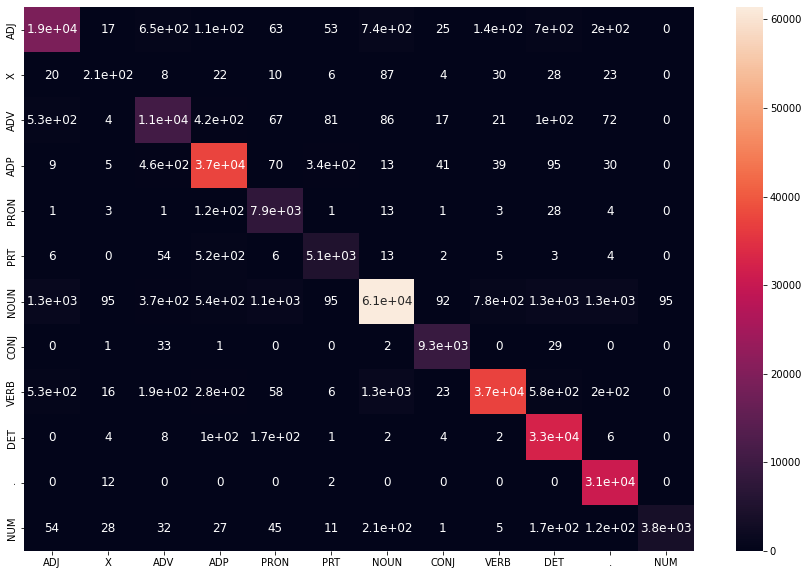

Weighted Precision : 0.9372025350372062
Weighted Recall : 0.9357536687362571
Weighted F1-score : 0.9355139787722437
Weighted F0.5-score : 0.9362973673247589
Weighted F2-score : 0.9354236984919468
Fold 4 :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Precision,0.856934,0.464286,0.876516,0.92364,0.854724,0.908329,0.961985,0.948319,0.974567,0.934962,0.950548,0.974807


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Recall,0.884575,0.362791,0.887033,0.970515,0.969825,0.862876,0.878776,0.993594,0.927233,0.983423,1.0,0.856369


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F1-score,0.870535,0.407311,0.881743,0.946497,0.908644,0.885019,0.9185,0.970428,0.950311,0.95858,0.974647,0.911758


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F0.5-score,0.862323,0.439684,0.8786,0.932649,0.875505,0.898859,0.944106,0.95704,0.964717,0.944268,0.960043,0.948569


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F2-score,0.878905,0.379377,0.884909,0.960763,0.94439,0.871599,0.894246,0.984196,0.936328,0.973333,0.989702,0.877697


Confusion Matrix :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
ADJ,11710.0,6.0,486.0,54.0,52.0,16.0,317.0,70.0,151.0,256.0,120.0,0.0
X,11.0,78.0,1.0,9.0,2.0,2.0,46.0,7.0,3.0,6.0,45.0,5.0
ADV,394.0,3.0,9611.0,322.0,51.0,179.0,86.0,27.0,37.0,69.0,56.0,0.0
ADP,14.0,3.0,320.0,23732.0,51.0,240.0,8.0,21.0,45.0,19.0,0.0,0.0
PRON,0.0,0.0,2.0,245.0,10349.0,0.0,3.0,2.0,5.0,65.0,0.0,0.0
PRT,5.0,0.0,65.0,644.0,29.0,5311.0,48.0,11.0,9.0,10.0,23.0,0.0
NOUN,999.0,53.0,272.0,280.0,1266.0,86.0,40059.0,125.0,589.0,844.0,968.0,44.0
CONJ,0.0,0.0,21.0,3.0,0.0,1.0,0.0,6514.0,0.0,17.0,0.0,0.0
VERB,514.0,20.0,171.0,236.0,53.0,9.0,958.0,86.0,32264.0,318.0,167.0,0.0
DET,0.0,0.0,8.0,154.0,230.0,0.0,1.0,6.0,0.0,23849.0,3.0,0.0


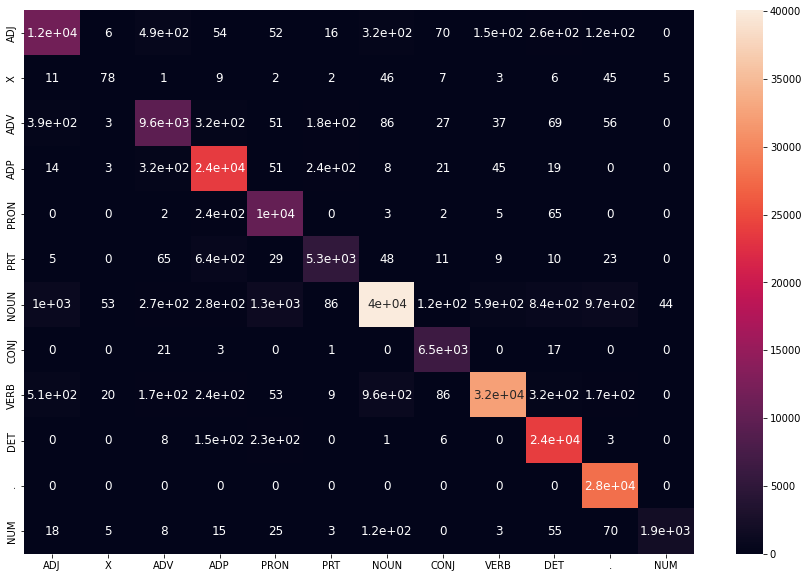

Weighted Precision : 0.9357176718383048
Weighted Recall : 0.9342804247893697
Weighted F1-score : 0.9339762036532319
Weighted F0.5-score : 0.9347724303967136
Weighted F2-score : 0.9339154614691795
Fold 5 :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Precision,0.840761,0.339394,0.866184,0.905764,0.894656,0.872768,0.95633,0.936398,0.97372,0.945204,0.976136,0.69745


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Recall,0.874886,0.309392,0.882416,0.957307,0.967934,0.840473,0.864884,0.995648,0.931715,0.976585,1.0,0.94403


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F1-score,0.857484,0.323699,0.874224,0.930823,0.929853,0.856316,0.908311,0.965114,0.952254,0.960638,0.987924,0.80222


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F0.5-score,0.847371,0.332937,0.869382,0.915624,0.90841,0.866112,0.936526,0.947677,0.965019,0.951318,0.980817,0.735893


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
F2-score,0.867841,0.314961,0.879121,0.946535,0.952333,0.846739,0.881747,0.983206,0.939823,0.970143,0.995134,0.881687


Confusion Matrix :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
ADJ,8622.0,14.0,462.0,39.0,47.0,6.0,267.0,63.0,128.0,106.0,64.0,37.0
X,12.0,56.0,5.0,3.0,9.0,2.0,51.0,6.0,6.0,6.0,6.0,19.0
ADV,398.0,6.0,9088.0,253.0,31.0,216.0,107.0,42.0,60.0,41.0,37.0,20.0
ADP,21.0,2.0,347.0,17647.0,22.0,322.0,11.0,25.0,20.0,15.0,2.0,0.0
PRON,4.0,0.0,3.0,196.0,13342.0,3.0,14.0,3.0,0.0,218.0,1.0,0.0
PRT,22.0,7.0,107.0,681.0,27.0,5474.0,69.0,23.0,22.0,17.0,2.0,62.0
NOUN,782.0,68.0,253.0,196.0,1155.0,243.0,29432.0,99.0,572.0,530.0,423.0,277.0
CONJ,0.0,0.0,5.0,2.0,0.0,1.0,0.0,5948.0,0.0,17.0,1.0,0.0
VERB,387.0,10.0,180.0,272.0,56.0,4.0,789.0,133.0,30086.0,182.0,170.0,22.0
DET,0.0,2.0,38.0,193.0,222.0,0.0,0.0,8.0,2.0,19561.0,2.0,2.0


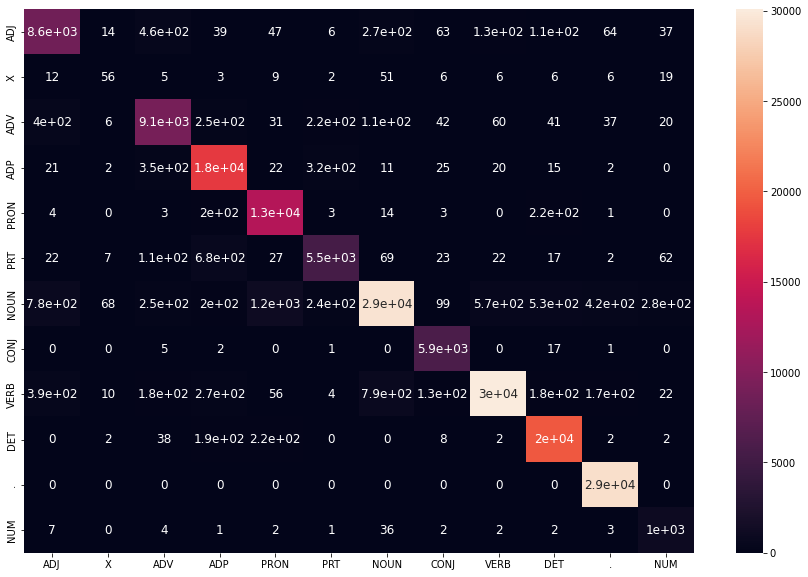

Weighted Precision : 0.9343663858408054
Weighted Recall : 0.9328269419320723
Weighted F1-score : 0.9326772179965195
Weighted F0.5-score : 0.9334696376816635
Weighted F2-score : 0.9325450064217011


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Average Precision,0.861051,0.384726,0.862683,0.921491,0.851317,0.896551,0.959487,0.957205,0.97178,0.924661,0.944998,0.922878


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Average Recall,0.882382,0.403239,0.883762,0.968678,0.961787,0.865943,0.875824,0.993391,0.919615,0.986393,0.999728,0.858564


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Average F1-score,0.871492,0.386598,0.873081,0.944453,0.903032,0.880906,0.915669,0.974898,0.944954,0.954428,0.971499,0.882497


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Average F0.5-score,0.865175,0.384003,0.866809,0.930531,0.871244,0.890208,0.941444,0.96419,0.960863,0.93632,0.955402,0.9048


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
Average F2-score,0.877971,0.394401,0.879455,0.958829,0.937347,0.871849,0.891322,0.985894,0.929581,0.973326,0.988218,0.866063


Confusion Matrix :


,ADJ,X,ADV,ADP,PRON,PRT,NOUN,CONJ,VERB,DET,.,NUM
ADJ,73916.0,82.0,2851.0,376.0,303.0,130.0,2424.0,204.0,695.0,2018.0,682.0,40.0
X,77.0,581.0,16.0,49.0,28.0,12.0,341.0,18.0,41.0,77.0,122.0,24.0
ADV,2356.0,16.0,49695.0,1842.0,237.0,677.0,439.0,135.0,177.0,382.0,263.0,20.0
ADP,68.0,13.0,1923.0,140386.0,270.0,1530.0,56.0,150.0,133.0,200.0,36.0,1.0
PRON,5.0,3.0,9.0,1375.0,47496.0,4.0,41.0,7.0,11.0,374.0,9.0,0.0
PRT,57.0,7.0,310.0,3157.0,72.0,25807.0,187.0,37.0,49.0,38.0,46.0,62.0
NOUN,6368.0,633.0,1547.0,2429.0,5699.0,585.0,241608.0,635.0,3753.0,5555.0,6235.0,511.0
CONJ,0.0,2.0,135.0,15.0,1.0,2.0,2.0,37892.0,0.0,101.0,1.0,0.0
VERB,2487.0,68.0,994.0,1545.0,331.0,27.0,5842.0,368.0,167975.0,2152.0,939.0,22.0
DET,1.0,6.0,69.0,687.0,912.0,2.0,11.0,27.0,4.0,135283.0,15.0,2.0


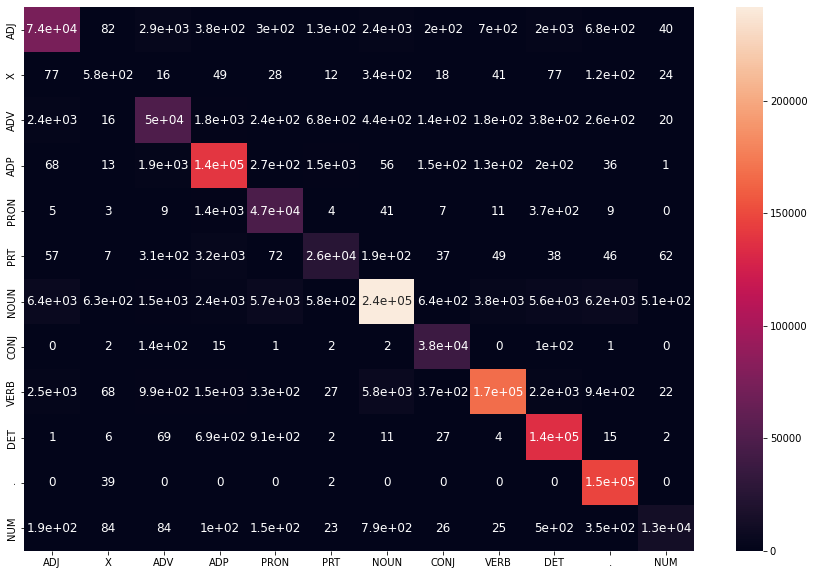

Overall average Precision : 0.9327232826511851
Overall average Recall : 0.9308428641568831
Overall average F1-score : 0.9306121405129358
Overall average F0.5-score : 0.9315940901830825
Overall average F2-score : 0.9304716664885362


In [6]:
for i in range(5):
    print("Fold", i+1, ":")
    display(pd.DataFrame(Precision[i].reshape((1, tagCount)), index = ["Precision"], columns = uniqueTags))

    display(pd.DataFrame(Recall[i].reshape(1, tagCount), index = ["Recall"], columns = uniqueTags))

    display(pd.DataFrame(F1Score[i].reshape(1, tagCount), index = ["F1-score"], columns = uniqueTags))

    display(pd.DataFrame(F05Score[i].reshape(1, tagCount), index = ["F0.5-score"], columns = uniqueTags))

    display(pd.DataFrame(F2Score[i].reshape(1, tagCount), index = ["F2-score"], columns = uniqueTags))

    print("Confusion Matrix :")
    df_cm = pd.DataFrame(ConfusionMatrix[i], index = uniqueTags, columns = uniqueTags)
    display(df_cm)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
    plt.show()

    print("Weighted Precision :", weightedPrecision[i])
    print("Weighted Recall :", weightedRecall[i])
    print("Weighted F1-score :", weightedF1Score[i])
    print("Weighted F0.5-score :", weightedF05Score[i])
    print("Weighted F2-score :", weightedF2Score[i])

avgPrecision = np.sum(Precision, axis = 0)/5
avgRecall = np.sum(Recall, axis = 0)/5
avgF1Score = np.sum(F1Score, axis = 0)/5
avgF05Score = np.sum(F05Score, axis = 0)/5
avgF2Score = np.sum(F2Score, axis = 0)/5

avgConfusionMatrix = np.zeros((tagCount, tagCount))
for i in range(5):
    avgConfusionMatrix += ConfusionMatrix[i]

display(pd.DataFrame(avgPrecision.reshape((1, tagCount)), index = ["Average Precision"], columns = uniqueTags))

display(pd.DataFrame(avgRecall.reshape(1, tagCount), index = ["Average Recall"], columns = uniqueTags))

display(pd.DataFrame(avgF1Score.reshape(1, tagCount), index = ["Average F1-score"], columns = uniqueTags))

display(pd.DataFrame(avgF05Score.reshape(1, tagCount), index = ["Average F0.5-score"], columns = uniqueTags))

display(pd.DataFrame(avgF2Score.reshape(1, tagCount), index = ["Average F2-score"], columns = uniqueTags))

print("Confusion Matrix :")
df_cm = pd.DataFrame(avgConfusionMatrix, index = uniqueTags, columns = uniqueTags)
display(df_cm)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.show()

print("Overall average Precision :", np.sum(weightedPrecision)/5)
print("Overall average Recall :", np.sum(weightedRecall)/5)
print("Overall average F1-score :", np.sum(weightedF1Score)/5)
print("Overall average F0.5-score :", np.sum(weightedF05Score)/5)
print("Overall average F2-score :", np.sum(weightedF2Score)/5)

In [15]:
sampleSentences = [["Parker", "meant", "business", "."], ["Why", "is", "the", "story", "interesting", "?"], ["I", "watched", "the", "movie", "on", "14/12", "."]
                   , ["Janaki", "is", "a", "good", "boy"]]
outputs = viterbi(sampleSentences)

for i in outputs:
    for j in i:
        print(uniqueTags[j], end = " ")
    print(" ", end = '\n')

NOUN VERB NOUN .  
ADV VERB DET NOUN ADJ .  
PRON VERB DET NOUN ADP NOUN .  
PRON VERB DET ADJ NOUN  
